Image-to-Image tasks apply when an application receives an image and outputs another image. This has various subtasks, including image enhancement (super resolution, low light enhancement, deraining and so on), image inpainting, and more.

This guide will show you how to:
1. Use an image-to-image  Swin2SR model pipeline for super resolution task,
2. Run inference using image-to-image model manually without a pipeline.

NB: image-to-image pipeline only supports super resolution task at the time of coding.

# Libraries

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import requests
import numpy as np
from PIL import Image
from transformers import pipeline, Swin2SRForImageSuperResolution, Swin2SRImageProcessor 

2024-10-07 21:13:16.220954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Image-to-image upscaling using pipeline

In [3]:
mps_device = torch.device("mps")
pipe = pipeline(task="image-to-image", model="caidas/swin2SR-lightweight-x2-64", device=mps_device)

/Users/nm/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


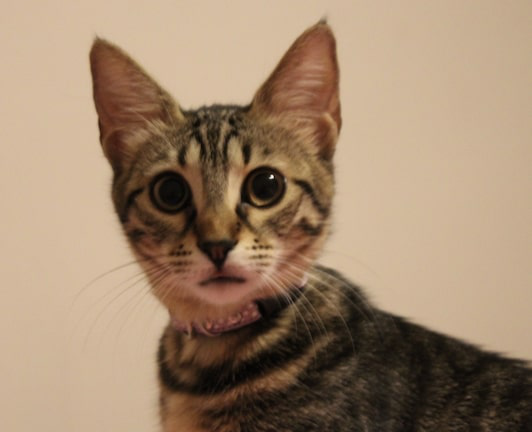

In [4]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/cat.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image

In [5]:
# Check image size before upscaling
print(image.size)

(532, 432)


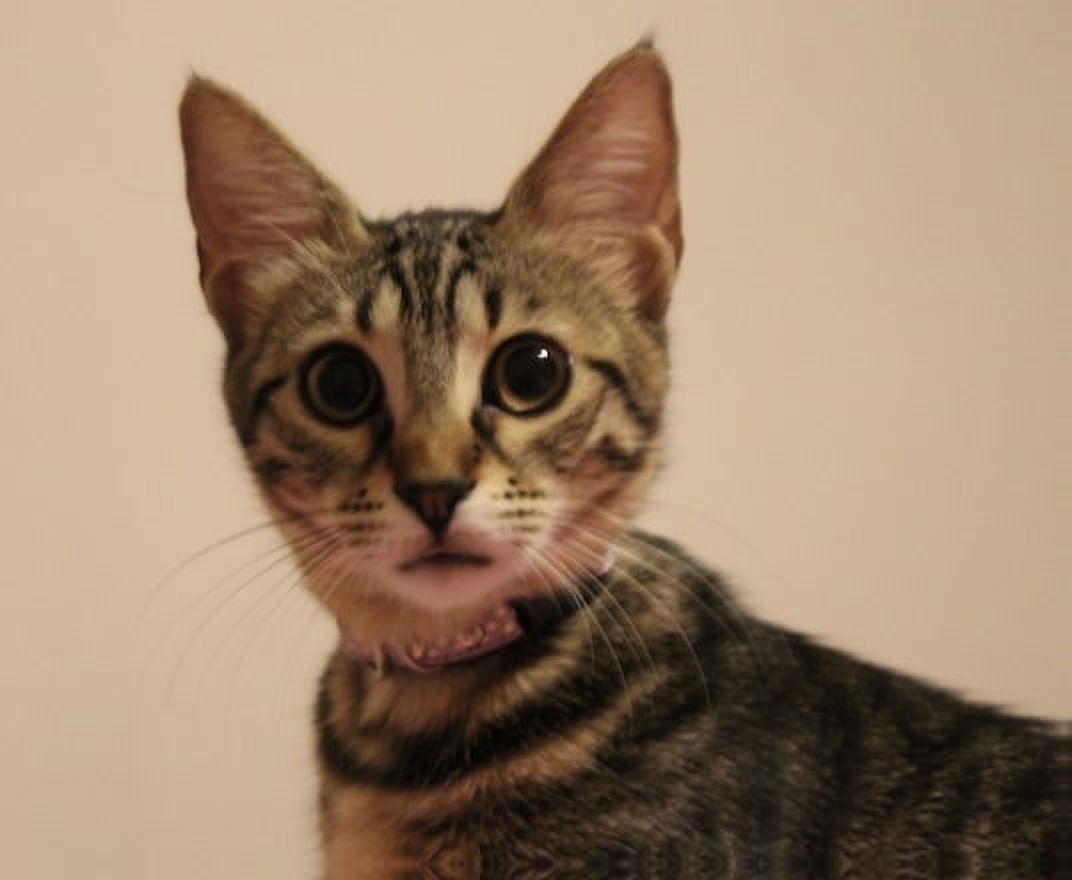

In [6]:
# Inference using the pipeline
upscaled = pipe(image)
upscaled

In [7]:
# Check size of image after upscaling
print(upscaled.size)

(1072, 880)


# Image-to-image upscaling manually without pipeline

In [8]:
model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-lightweight-x2-64").to(mps_device)
processor = Swin2SRImageProcessor("caidas/swin2SR-lightweight-x2-64")

In [9]:
# pipeline simply abstracts away the preprocessing and postprocessing steps, so we have to do these ourselves here
# Pass the image to the preprocessor
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

# Move the pixel values to GPU
pixel_values = pixel_values.to(mps_device)

torch.Size([1, 3, 440, 536])


In [10]:
# Run ineference by passing pixel values to the model
with torch.no_grad():
    outputs = model(pixel_values)
    # NB: Output is an object of type ImageSuperResolutionOutput
    print(outputs)
    print(outputs.reconstruction.data.shape)

ImageSuperResolutionOutput(loss=None, reconstruction=tensor([[[[0.8269, 0.8269, 0.8275,  ..., 0.7459, 0.7441, 0.7448],
          [0.8287, 0.8277, 0.8283,  ..., 0.7456, 0.7453, 0.7457],
          [0.8280, 0.8272, 0.8269,  ..., 0.7451, 0.7453, 0.7460],
          ...,
          [0.7923, 0.7924, 0.7918,  ..., 0.1048, 0.1046, 0.1060],
          [0.7927, 0.7926, 0.7931,  ..., 0.1027, 0.1038, 0.1063],
          [0.7937, 0.7917, 0.7929,  ..., 0.1019, 0.1058, 0.1082]],

         [[0.7256, 0.7246, 0.7256,  ..., 0.6522, 0.6516, 0.6523],
          [0.7261, 0.7253, 0.7258,  ..., 0.6511, 0.6509, 0.6515],
          [0.7260, 0.7253, 0.7252,  ..., 0.6511, 0.6506, 0.6513],
          ...,
          [0.6903, 0.6906, 0.6903,  ..., 0.0857, 0.0847, 0.0860],
          [0.6907, 0.6910, 0.6914,  ..., 0.0834, 0.0838, 0.0861],
          [0.6906, 0.6896, 0.6910,  ..., 0.0820, 0.0851, 0.0877]],

         [[0.6285, 0.6277, 0.6287,  ..., 0.5493, 0.5485, 0.5491],
          [0.6278, 0.6277, 0.6290,  ..., 0.5495, 0.5485

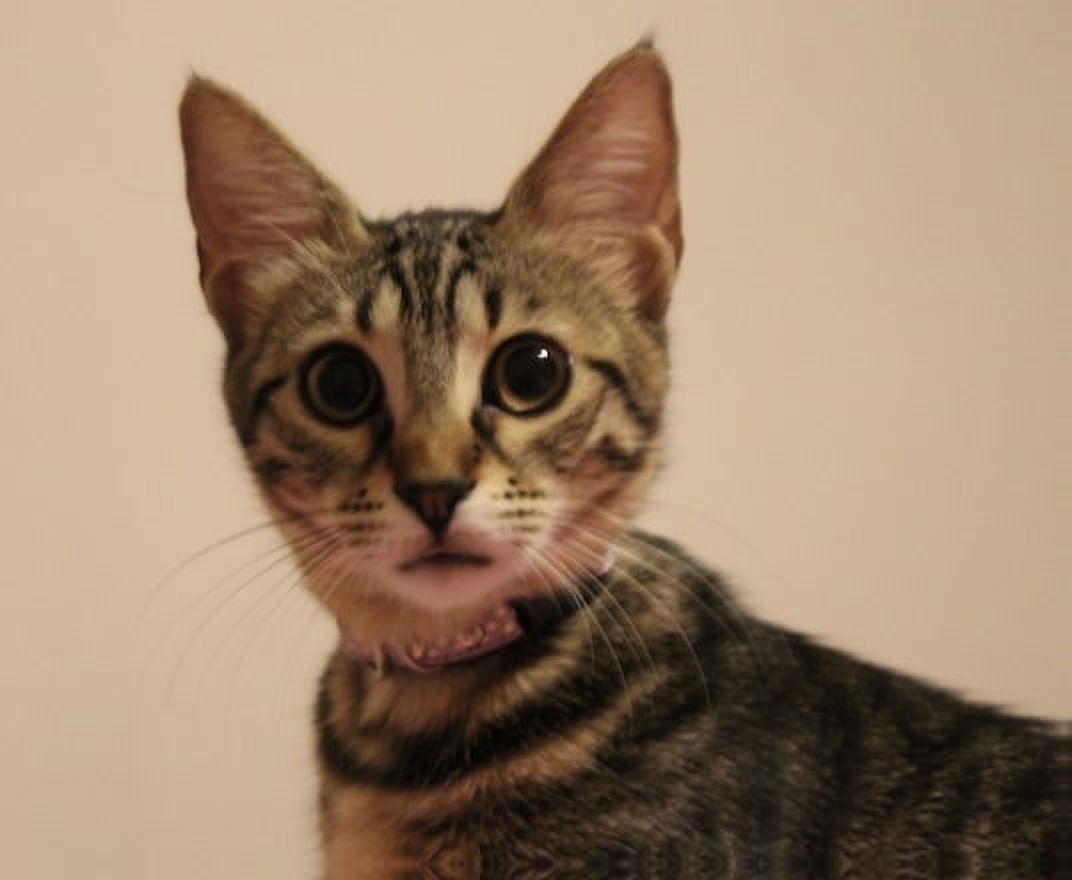

In [11]:
# Final postprocessing
# Squeeze the output and get rid of axis 0, take to CPU and clip the values
output = outputs.reconstruction.data.squeeze().cpu().clamp_(0, 1).numpy()
# Rearrange the axes to have the shape [1072, 880] as principal dimensions of ImageSuperResolutionOutput object
output = np.moveaxis(output, source=0, destination=-1)
# Bring values back to pixel values range [0, 255]
output = (output * 255.0).round().astype(np.uint8)
Image.fromarray(output)